## Assignment 1: Machine Learning Methods

### Pranshu Raj Goel a1875750

#### How can we use data analytics to predict energy usage for this house?

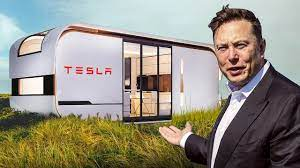


### 1. Read the dataset

In [ ]:
#importing all needed libraries
from pathlib import Path  
from matplotlib import pyplot as plot
from pathlib import Path  
import pandas as pandas
import numpy as numpy
from sklearn.model_selection import train_test_split
import seaborn as seaborn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Extractign the data from dataset and dropping NA Columns
dataframe = pandas.read_csv("energydata_complete-1.csv")

In [ ]:
# List of Constants and Configurations
TEST_SIZE_RATIO = 0.20
RANDOM_STATE_SEED = 1875750

### 2. Analyse and visualise the data

In [ ]:
# Removing any N/A rows present
dataframe = dataframe.dropna()

In [ ]:
# Preprocessing the dataframe to extract as much data as possible.
# TypeCase the datetimestamp from string to datetime format to facillitate easier extraction of data.
dataframe["date"] = pandas.to_datetime(dataframe['date'], format='%Y-%m-%d %H:%M:%S')
# Extracted Number of Seconds from Midnight(NSM), to check how day night cycle affect electricity consumption.
dataframe["NSM"] = (dataframe["date"] - pandas.to_datetime(dataframe['date'].dt.date, format='%Y-%m-%d')).dt.total_seconds()
# Extracted If the day was a weekday(1 for Mon - Fri; 0 Sat & Sun)
dataframe["week_status"] = dataframe["date"].apply(lambda date: 1 if(date.weekday() <= 4) else 0)
# Extracted If the day was Monday 
dataframe["day_of_monday"] = dataframe["date"].apply(lambda date: date.weekday() == 0)
# Extracted If the day was Tuesday 
dataframe["day_of_tuesday"] = dataframe["date"].apply(lambda date: date.weekday() == 1)
# Extracted If the day was Wednsday 
dataframe["day_of_wednesday"] = dataframe["date"].apply(lambda date: date.weekday() == 2)
# Extracted If the day was Thursday 
dataframe["day_of_thursday"] = dataframe["date"].apply(lambda date: date.weekday() == 3)
# Extracted If the day was Friday 
dataframe["day_of_friday"] = dataframe["date"].apply(lambda date: date.weekday() == 4)
# Extracted If the day was Saturday 
dataframe["day_of_saturday"] = dataframe["date"].apply(lambda date: date.weekday() == 5)
# Extracted If the day was Sunday 
dataframe["day_of_sunday"] = dataframe["date"].apply(lambda date: date.weekday() == 6)

In [ ]:
# Droping Date column as we have extracted nessesary data.
# Furthermore, the prediction cannpt be performed on date as we only have data for few months rather than all year round.
dataframe = dataframe.drop("date", axis = 1).dropna()

In [ ]:
# Printing First few Rows of dataset to verify if dataframe has been transformed correctly.
dataframe.head()

In [ ]:
# Printing features in the dataset.
print(list(dataframe.columns))

In [ ]:
# Printing schema of teh dataframe.
dataframe.info()

In [ ]:
# Printing stats about each feature in the dataset.
dataframe.describe()

In [ ]:
# Plot the inter-dependencies of feathers in the dataset with each other
plot.figure(figsize=(10, 10))
seaborn.heatmap(dataframe.corr(), xticklabels=dataframe.columns, yticklabels=dataframe.columns)
plot.show()

In [ ]:
# Plot the dependencies of features with respect to target Column: Appliances
plot.figure(figsize=(16, 1))
axes = seaborn.heatmap([dataframe.corrwith(dataframe["Appliances"])], xticklabels=dataframe.columns)
plot.show()

# Printing the correleation seperately onto console for more readability.
print("Feature Name \tCorreleation")
print(round(dataframe.corrwith(dataframe["Appliances"]).sort_values(ascending=False), 5))

In [ ]:
# Seperating dependent(Appliances) and independant features(all features except Appliances) 
X = dataframe.drop("Appliances", axis = 1)
y = dataframe["Appliances"]

# Splitting the dataset into 2 parts for training and testing the model respectively.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE_RATIO, random_state=RANDOM_STATE_SEED)

prediction_dataset = {
    "full": (X, y), 
    "train": (X_train, y_train), 
    "test": (X_test, y_test)
}

prediction_dataset_columns = list(prediction_dataset.keys())
metrics_columns = ["mean_absolute_error", "mean_absolute_percentage_error", "r2_score", "root_mean_square_error"]
model_list = ["GradientBoostingRegressor", "RandomForestRegressor"]

### 3. Implement prediction models

#### Gradient Boosted Regression

In [ ]:
# Configuration for GBR
GBR_N_ESTIMATORS = 100
GBR_MAX_DEPTH_SET = [1, 2, 3]
GBR_VERBOSE = 1

# Declaring and Initilizing performance variable to score metrics
gbr_performance = pandas.DataFrame(data={"prediction_set": {}, "metric": {}, "depth": {}, "boosting_iteration": {}, "value": {}})
gbr_feature_importance = pandas.DataFrame()

# Applying Gradient Boosting Regression model to the dataset.
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
gradient_boosting_regressor = GradientBoostingRegressor()

#### Random Forest

In [ ]:
# Configuration for GBR
RFR_N_ESTIMATORS_SET = range(1,11)
RFR_VERBOSE = 1
RFR_RANDOM_STATE_SEED = RANDOM_STATE_SEED

# Declaring and Initilizing performance variable to score metrics
rfr_performance = pandas.DataFrame(data={"prediction_set": {}, "metric": {}, "n_estimators": {}, "value": {}})
rfr_feature_importance = pandas.DataFrame()

# Applying Gradient Boosting Regression model to the dataset.
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
random_forest_regressor = RandomForestRegressor()

### 4. Train prediction models

#### Gradient Boosted Regression

In [ ]:
for depth_iterator in GBR_MAX_DEPTH_SET:
    print("\nTraining Gradient Boosted Regression Model for MAX_DEPTH: %d" %depth_iterator)

    # Adding parameters for the SVR.
    gradient_boosting_regressor.set_params(n_estimators = GBR_N_ESTIMATORS)
    gradient_boosting_regressor.set_params(max_depth = depth_iterator)
    gradient_boosting_regressor.set_params( verbose = GBR_VERBOSE)

    # Parallelizing the training to speed up the training time.
    # Reference: https://scikit-learn.org/stable/computing/parallelism.html
    with joblib.parallel_backend(backend = "loky", n_jobs = -1):
        gradient_boosting_regressor.fit(X_train, y_train)
    
    # Calculate the metrics for the model.
    # Reference: https://scikit-learn.org/stable/modules/model_evaluation.html
    for prediction_set in prediction_dataset.keys():
        # Helps predict the target values at each boositng iteration. 
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.predict
        for boosting_iteration, y_pred in enumerate(gradient_boosting_regressor.staged_predict(prediction_dataset[prediction_set][0])):
            gbr_performance.loc[len(gbr_performance)] = {
                "prediction_set": prediction_set,
                "metric": "root_mean_square_error",
                "depth": depth_iterator,
                "boosting_iteration": boosting_iteration + 1,
                "value": mean_squared_error(prediction_dataset[prediction_set][1], y_pred)
            }
            gbr_performance.loc[len(gbr_performance)] = {
                "prediction_set": prediction_set,
                "metric": "r2_score",
                "depth": depth_iterator,
                "boosting_iteration": boosting_iteration + 1,
                "value": r2_score(prediction_dataset[prediction_set][1], y_pred)
            }
            gbr_performance.loc[len(gbr_performance)] = {
                "prediction_set": prediction_set,
                "metric": "mean_absolute_error",
                "depth": depth_iterator,
                "boosting_iteration": boosting_iteration + 1,
                "value": mean_absolute_error(prediction_dataset[prediction_set][1], y_pred)
            }
            gbr_performance.loc[len(gbr_performance)] = {
                "prediction_set": prediction_set,
                "metric": "mean_absolute_percentage_error",
                "depth": depth_iterator,
                "boosting_iteration": boosting_iteration + 1,
                "value": mean_absolute_percentage_error(prediction_dataset[prediction_set][1], y_pred)
            }            

# Save the importance of the feature w.r.t the most important feature.
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor.feature_importances_
feature_importance = gradient_boosting_regressor.feature_importances_
releative_feature_importance = (feature_importance / feature_importance.max()) * 100
sorted_indices=numpy.argsort(releative_feature_importance)
gbr_feature_importance = pandas.DataFrame(data = {"feature_names": X.columns[sorted_indices], "releative_feature_importance": releative_feature_importance[sorted_indices], "feature_importance": feature_importance[sorted_indices]})

#### Random Forest Regression

In [ ]:
for n_estimators in RFR_N_ESTIMATORS_SET:
    print(f"\nTraining Random Forest Regression Model for n_estimators: {n_estimators}")

    # Adding parameters for the RFR.
    random_forest_regressor.set_params(n_estimators = n_estimators)
    random_forest_regressor.set_params(n_jobs = -1)
    random_forest_regressor.set_params(random_state=RFR_RANDOM_STATE_SEED)
    random_forest_regressor.set_params(verbose = RFR_VERBOSE)

    #Start training the Model.
    random_forest_regressor.fit(X_train, y_train)
    
    # Calculate the metrics for the model.
    # Reference: https://scikit-learn.org/stable/modules/model_evaluation.html
    for prediction_set in prediction_dataset.keys():
        # Helps predict the target values at each boositng iteration. 
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor.staged_predict
        y_pred = random_forest_regressor.predict(prediction_dataset[prediction_set][0])
        rfr_performance.loc[len(rfr_performance)] = {
            "prediction_set": prediction_set,
            "metric": "root_mean_square_error",
            "n_estimators": n_estimators,
            "value": mean_squared_error(prediction_dataset[prediction_set][1], y_pred)
        }
        rfr_performance.loc[len(rfr_performance)] = {
            "prediction_set": prediction_set,
            "metric": "r2_score",
            "n_estimators": n_estimators,
            "value": r2_score(prediction_dataset[prediction_set][1], y_pred)
        }
        rfr_performance.loc[len(rfr_performance)] = {
            "prediction_set": prediction_set,
            "metric": "mean_absolute_error",
            "n_estimators": n_estimators,
            "value": mean_absolute_error(prediction_dataset[prediction_set][1], y_pred)
        }
        rfr_performance.loc[len(rfr_performance)] = {
            "prediction_set": prediction_set,
            "metric": "mean_absolute_percentage_error",
            "n_estimators": n_estimators,
            "value": mean_absolute_percentage_error(prediction_dataset[prediction_set][1], y_pred)
        }            

# Save the importance of the feature w.r.t the most important feature.
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_
feature_importance = random_forest_regressor.feature_importances_
releative_feature_importance = (feature_importance / feature_importance.max()) * 100
sorted_indices=numpy.argsort(releative_feature_importance)
rfr_feature_importance = pandas.DataFrame(data = {"feature_names": X.columns[sorted_indices], "releative_feature_importance": releative_feature_importance[sorted_indices], "feature_importance": feature_importance[sorted_indices]})

### 5. Test predictin models and show results

#### Gradient Boosting Regression

In [ ]:
# Visualize model's metrics using line graph subplots.
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
figure, axesMatrix = plot.subplots(4,3)
plot.tight_layout()
graph_dataset = gbr_performance
for prediction_set in graph_dataset["prediction_set"].sort_values().unique():
    graph_pred = graph_dataset.where(graph_dataset["prediction_set"] == prediction_set).dropna()
    for metric in graph_pred["metric"].sort_values().unique():
        graph_pm = graph_pred.where(graph_pred["metric"] == metric).dropna()
        graph = axesMatrix[metrics_columns.index(metric), prediction_dataset_columns.index(prediction_set)]
        graph.set_title(f"\n\n{metric} vs Boosting Iteration\n(Calculated upon: {prediction_set} dataset)")
        graph.set_xlabel('Boosting Iterations')
        graph.set_ylabel(metric)
        for depth in graph_pm["depth"].sort_values().unique():
            graph_pmd = graph_pm.where(graph_pm["depth"] == depth).dropna()
            graph.plot(graph_pmd["boosting_iteration"], graph_pmd["value"], label = "max_depth: "  + str(int(depth)))
        graph.legend(loc='upper right')

figure.set_figheight(18)
figure.set_figwidth(16)
figure.suptitle("\nMetrics to select optimal parameters for GBR\n")
figure.tight_layout()
plot.show()


In [ ]:
# Visualize feature importance of the model using bar graph subplots.
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
figure, (plot1, plot2) = plot.subplots(1, 2)

plot1.barh(gbr_feature_importance["feature_names"], gbr_feature_importance["releative_feature_importance"], align="center")
plot1.set_xlabel('Relative Importance')
plot1.set_title('Releative Feature Importance')

plot2.barh(gbr_feature_importance["feature_names"], gbr_feature_importance["feature_importance"], align="center")
plot2.set_xlabel('Feature Importance')
plot2.set_title('Feature Importance')

figure.set_figheight(9)
figure.set_figwidth(16)
figure.tight_layout()
plot.show()

gbr_feature_importance.sort_values(by=["releative_feature_importance"], ascending = False).head(len(X))

#### Random Forest Regression

In [ ]:
# Visualize model's metrics using line graph subplots.
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
figure, axesMatrix = plot.subplots(4,3)
plot.tight_layout()
graph_dataset = rfr_performance
for prediction_set in graph_dataset["prediction_set"].sort_values().unique():
    graph_pred = graph_dataset.where(graph_dataset["prediction_set"] == prediction_set).dropna()
    for metric in graph_pred["metric"].sort_values().unique():
        graph_pm = graph_pred.where(graph_pred["metric"] == metric).dropna()
        graph = axesMatrix[metrics_columns.index(metric), prediction_dataset_columns.index(prediction_set)]
        graph.set_title(f"\n\n{metric} vs n_estimators\n(Calculated upon: {prediction_set} dataset)")
        graph.set_xlabel('n_estimators')
        graph.set_ylabel(metric)
        graph.plot(graph_pm["n_estimators"], graph_pm["value"])

figure.set_figheight(18)
figure.set_figwidth(16)
figure.suptitle("\nMetrics to select optimal parameters for RFR\n")
figure.tight_layout()
plot.show()


In [ ]:
# Visualize feature importance of the model using bar graph subplots.
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
figure, (plot1, plot2) = plot.subplots(1, 2)

graph_dataset = rfr_feature_importance
plot1.barh(graph_dataset["feature_names"], graph_dataset["releative_feature_importance"], align="center")
plot1.set_xlabel('Relative Importance')
plot1.set_title('Releative Feature Importance')

plot2.barh(graph_dataset["feature_names"], graph_dataset["feature_importance"], align="center")
plot2.set_xlabel('Feature Importance')
plot2.set_title('Feature Importance')

figure.set_figheight(9)
figure.set_figwidth(16)
figure.tight_layout()
plot.show()

graph_dataset.sort_values(by=["releative_feature_importance"], ascending = False).head(len(X))

### 6. Compare the results from all candidate models, choose the best model, justify your choice and discuss the results

In [ ]:
# Initilizing the best_performance dataframe to store best performance of models
best_performance = pandas.DataFrame(data={"prediction_set": {},"metric": {}, "model": {}, "value": {}})

for prediction_set in prediction_dataset_columns:
    for model in model_list:
        for metric in metrics_columns:
            # Initilizing the model_metric_dataframe dataframe depending upon the model's value
            model_metric_dataframe = pandas.DataFrame()
            if model == "GradientBoostingRegressor":
                model_metric_dataframe = gbr_performance
            elif model == "RandomForestRegressor":
                model_metric_dataframe = rfr_performance

            # Filter model_metric_dataframe to have data for iterated prediction_set & metric
            model_metric_dataframe = model_metric_dataframe.loc[((model_metric_dataframe["prediction_set"] == prediction_set) & (model_metric_dataframe["metric"] == metric))]
            
            # Partition over dataframe where 
            #   columns are grouped over columns("prediction_set", "metric") and 
            #   partitioned rows are ordered based on column("value")
            # Convert result into Dataframe
            model_metric_dataframe = model_metric_dataframe.sort_values("value").groupby(by = ["prediction_set", "metric"])["value"].apply(pandas.DataFrame)
            
            # Select column("value") by providing MultiIndex and dropping any N/A rows
            model_metric_dataframe = model_metric_dataframe[prediction_set, metric].dropna()

            # Inserting the values into best_performance dataframe
            best_performance.loc[len(best_performance)] = {
                "prediction_set": prediction_set, 
                "model": model, 
                "metric": metric, 
                "value": model_metric_dataframe.max() if "metric" == "r2_score" else model_metric_dataframe.min()
            }

# Pivot Table for better readability.
best_performance = pandas.pivot_table(best_performance, values="value", index = ["prediction_set", "metric"], columns = ["model"])

# Displaying the Resulting Table
best_performance.head(len(best_performance))

### 7. Reflect on what you have learned by completing this assignment

### 8. References

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

https://scikit-learn.org/stable/computing/parallelism.html

https://scikit-learn.org/stable/modules/model_evaluation.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor.staged_predict

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor.feature_importances_

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.predict

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_

https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html